<a href="https://colab.research.google.com/github/mmistroni/TensorFlowPlayground/blob/master/EventProfiler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install QSTK

In [2]:
!pip install pandas_datareader

<h3> Fetching all tickers from sp500</h2>

In [3]:
def get_sp500_tickers():
  import bs4 as bs    
  import pickle    
  import requests    
  import lxml    
  resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')        
  soup = bs.BeautifulSoup(resp.text,'lxml')        
  table = soup.find('table', {'class': 'wikitable sortable'})        

  tickers = []

  for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[1].text
    tickers.append(str(ticker))

  return tickers    

res = get_sp500_tickers()
res

['MMM',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADBE',
 'AMD',
 'AAP',
 'AES',
 'AMG',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALXN',
 'ALGN',
 'ALLE',
 'AGN',
 'ADS',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'APC',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AIV',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM',
 'ARNC',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BHGE',
 'BLL',
 'BAC',
 'BK',
 'BAX',
 'BBT',
 'BDX',
 'BRK-B',
 'BBY',
 'BIIB',
 'BLK',
 'HRB',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BHF',
 'BMY',
 'AVGO',
 'BR',
 'BF-B',
 'CHRW',
 'COG',
 'CDNS',
 'CPB',
 'COF',
 'CPRI',
 'CAH',
 'KMX',
 'CCL',
 'CAT',
 'CBOE',
 'CBRE',
 'CBS',
 'CE',
 'CELG',
 'CNC',
 'CNP',
 'CTL',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'XEC',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS

<h2>Writing code to fetch data from yahoo (use IEX for recent data) </h2>

In [0]:
def get_data_from_yahoo(start, end, ticker, source='iex'):
  
  import pandas_datareader.data as dr
  import numpy as np
  from datetime import datetime
  try:
    return dr.DataReader(ticker, source, start, end)[['close']].rename(columns={'close': ticker})
  except Exception as e:
    print 'Exception when retrieving data for %s' % ticker



<h2> Importing required lbraries.(This code is borrowed from Computational Investing. course code only works for past data)</h2>

In [0]:


import pandas as pd; pd.TimeSeries = pd.Series


import numpy as np
import math
import copy
import QSTK.qstkutil.qsdateutil as du
import datetime as dt
import QSTK.qstkutil.DataAccess as da
import QSTK.qstkutil.tsutil as tsu
import QSTK.qstkstudy.EventProfiler as ep


<h2> Importing functions from tutorial3 to reuse event profiler </h2>

In [0]:
def find_events(ls_symbols, d_data):
    ''' Finding the event dataframe '''
    df_close = d_data['close']
    ts_market = df_close['SPY']
    # Got it. we need to replace this with pandas.datareader
    print "Finding Events"

    # Creating an empty dataframe
    df_events = copy.deepcopy(df_close)
    df_events = df_events * np.NAN

    # Time stamps for the event range
    ldt_timestamps = df_close.index

    print 'Loopingthrough all symbols....'
    for s_sym in ls_symbols:
        try:
          for i in range(1, len(ldt_timestamps)):
              # Calculating the returns for this timestamp
              f_symprice_today = df_close[s_sym].ix[ldt_timestamps[i]]
              f_symprice_yest = df_close[s_sym].ix[ldt_timestamps[i - 1]]
              f_marketprice_today = ts_market.ix[ldt_timestamps[i]]
              f_marketprice_yest = ts_market.ix[ldt_timestamps[i - 1]]
              f_symreturn_today = (f_symprice_today / f_symprice_yest) - 1
              f_marketreturn_today = (f_marketprice_today / f_marketprice_yest) - 1
              
              # Event is found if the symbol is down more then 3% while the
              # market is up more then 2%
              if f_symreturn_today <= -0.03 and f_marketreturn_today >= 0.02:
              # checking impact of 10% drop
              #if f_symprice_today <= f_symprice_yest * 0.9:
                  print 'Found event for  {}'.format(s_sym)
                  df_events[s_sym].ix[ldt_timestamps[i]] = 1
        except Exception as e:
            print 'Exception %s ' % str(e)
          

    return df_events


In [0]:
def kick_off_events(start_date, end_date):
    ls_symbols = get_sp500_tickers()
    ls_symbols.append('SPY')
    print 'About to get data for {}'.format(','.join(ls_symbols))
    ls_keys = ['close', 'volume']
    ldf_data = [get_data_from_yahoo(start_date, end_date, ticker) for ticker in ls_symbols]
    from pprint import pprint
    d_data = pd.concat(ldf_data, axis=1)
    
    for s_key in ls_symbols:
        try: 
          d_data[s_key] = d_data[s_key].fillna(method='ffill')
          d_data[s_key] = d_data[s_key].fillna(method='bfill')
          d_data[s_key] = d_data[s_key].fillna(1.0)
        except Exception as e:
          print 'Exception in dealing with %s data' % s_key

    print 'Finding event snow.....'
    print d_data.keys()
    df_events = find_events(ls_symbols, dict(close=d_data))
    print "Creating Study for {}".format(len(df_events))
    print df_events.info()
    df_events.to_csv('EventProfile%s.csv')
    ep.eventprofiler(df_events, dict(close=d_data), i_lookback=20, i_lookforward=20,
                s_filename='MyEventStudy-%s.pdf' , b_market_neutral=True, b_errorbars=True,
                s_market_sym='SPY')
    
  
  
  

About to get data for MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,AFL,A,APD,AKAM,ALK,ALB,ARE,ALXN,ALGN,ALLE,AGN,ADS,LNT,ALL,GOOGL,GOOG,MO,AMZN,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,APC,ADI,ANSS,ANTM,AON,AOS,APA,AIV,AAPL,AMAT,APTV,ADM,ARNC,ANET,AJG,AIZ,T,ADSK,ADP,AZO,AVB,AVY,BHGE,BLL,BAC,BK,BAX,BBT,BDX,BRK-B,BBY,BIIB,BLK,HRB,BA,BKNG,BWA,BXP,BSX,BHF,BMY,AVGO,BR,BF-B,CHRW,COG,CDNS,CPB,COF,CPRI,CAH,KMX,CCL,CAT,CBOE,CBRE,CBS,CE,CELG,CNC,CNP,CTL,CERN,CF,SCHW,CHTR,CVX,CMG,CB,CHD,CI,XEC,CINF,CTAS,CSCO,C,CFG,CTXS,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,CXO,COP,ED,STZ,COO,CPRT,GLW,COST,COTY,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,FANG,DLR,DFS,DISCA,DISCK,DISH,DG,DLTR,D,DOV,DWDP,DTE,DRE,DUK,DXC,ETFC,EMN,ETN,EBAY,ECL,EIX,EW,EA,EMR,ETR,EOG,EFX,EQIX,EQR,ESS,EL,EVRG,ES,RE,EXC,EXPE,EXPD,EXR,XOM,FFIV,FB,FAST,FRT,FDX,FIS,FITB,FE,FRC,FISV,FLT,FLIR,FLS,FLR,FMC,FL,F,FTNT,FTV,FBHS,BEN,FCX,GPS,GRMN,IT,GD,GE,GIS,GM,GPC,GILD,GPN,GS,GT,GWW,HAL,HBI,HOG,HRS,HIG,HAS,HCA,HCP,HP,HSIC,HSY,HES,HPE,

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Exception 'BRK-B' 
Found event for  BLK


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Exception 'BF-B' 
Found event for  CPRI
Found event for  KMX
Found event for  CME
Found event for  COTY
Found event for  DXC
Found event for  GWW
Found event for  SJM
Found event for  TIF
Creating Study for 251
<class 'pandas.core.frame.DataFrame'>
Index: 251 entries, 2018-01-02 to 2018-12-31
Columns: 504 entries, MMM to SPY
dtypes: float64(504)
memory usage: 1000.3+ KB
None


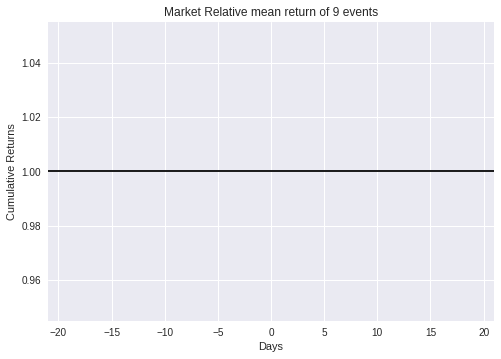

In [35]:
from datetime import date
res = get_data_from_yahoo(date(2019,1,10), date(2019,1,30), 'SPY')
res

kick_off_events(date(2018,1,1), date(2018,12,31))
